In [42]:
# !pip install pyscf==2.6.0
# !pip install openfermion==1.6.1
# !echo cuda-quantum | sudo -S apt-get install -y cuda-toolkit-11.8 && python -m pip install cupy==13.1.0
# !pip install git+https://github.com/yfhuang93/ipie/tree/msd_gpu
# !pip install ipie==0.7.0


In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pyscf import gto, scf, ao2mo, mcscf
import h5py

from openfermion import jordan_wigner
from openfermion import generate_hamiltonian

from src.vqe_cudaq_qnp import VqeQnp
from src.vqe_cudaq_qnp import get_cudaq_hamiltonian


from ipie.config import config
config.update_option("use_gpu", False)

from ipie.hamiltonians.generic import Generic as HamGeneric
from ipie.qmc.afqmc import AFQMC
from ipie.systems.generic import Generic
from ipie.trial_wavefunction.particle_hole import ParticleHole
from ipie.analysis.extraction import extract_observable

from src.utils_ipie import get_coeff_wf, gen_ipie_input_from_pyscf_chk

In [44]:
np.random.seed(12)
target = "nvidia"

num_active_orbitals = 6
num_active_electrons = 8
spin = 0
charge = 0

num_active_electrons_alpha = (num_active_electrons + spin) // 2
num_active_electrons_beta = (num_active_electrons - spin) // 2

atom = "systems/O3_spin_0/geo.xyz"
basis = "cc-pVQZ"

file_chk = "scf_mwe.chk"

n_vqe_layers = 1


In [45]:

# PYSCF 

mol = gto.M(
    atom=atom,
    spin=spin,
    charge=charge,
    basis=basis,
    verbose=4
)

nocca, noccb = mol.nelec
mol_nelec = mol.nelec
mf = scf.ROHF(mol)

# print(f"# saving chkfile to {file_chk}")

mf.chkfile = file_chk
mf.kernel()

System: uname_result(system='Linux', node='gorby', release='5.4.0-182-generic', version='#202-Ubuntu SMP Fri Apr 26 12:29:36 UTC 2024', machine='x86_64')  Threads 128
Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy 1.25.2  scipy 1.10.1  h5py 3.11.0
Date: Fri Jun  7 11:51:57 2024
PySCF version 2.6.0
PySCF path  /usr/local/lib/python3.10/dist-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 3
[INPUT] num. electrons = 24
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 O      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0
[INPUT]  2 O      0.000000000000   0.000000000000   1.271700000000 AA    0.000000000000   0.000000000000   2.403164712609 Bohr   0.0
[

-224.35854603286586

In [46]:
## VQE 

my_casci = mcscf.CASCI(mf, num_active_orbitals, num_active_electrons)
ss = (mol.spin / 2 * (mol.spin / 2 + 1))
my_casci.fix_spin_(ss=ss)

e_tot, e_cas, fcivec, mo_output, mo_energy = my_casci.kernel()

h1, energy_core = my_casci.get_h1eff()
h2 = my_casci.get_h2eff()
h2_no_symmetry = ao2mo.restore('1', h2, num_active_orbitals)
tbi = np.asarray(h2_no_symmetry.transpose(0, 2, 3, 1), order='C')

mol_ham = generate_hamiltonian(h1, tbi, energy_core.item(), EQ_TOLERANCE=1e-8)
jw_hamiltonian = jordan_wigner(mol_ham)

hamiltonian_cudaq, energy_core = get_cudaq_hamiltonian(jw_hamiltonian)

n_qubits = 2 * num_active_orbitals

n_alpha_vec = np.array([1] * num_active_electrons_alpha + [0] * (num_active_orbitals - num_active_electrons_alpha))
n_beta_vec = np.array([1] * num_active_electrons_beta + [0] * (num_active_orbitals - num_active_electrons_beta))
init_mo_occ = (n_alpha_vec + n_beta_vec).tolist()

options = {'maxiter': 100,
            'energy_core': energy_core,
            'initial_parameters': None,
            'return_final_state_vec': True}

vqe = VqeQnp(n_qubits=n_qubits,
                n_layers=n_vqe_layers,
                init_mo_occ=init_mo_occ,
                target=target)

results = vqe.run_vqe_cudaq(hamiltonian_cudaq, options=options)
energy_optimized = results['energy_optimized']

final_state_vector = results["state_vec"]
energies_vqe = results["callback_energies"]

# np.savetxt("wave_function.dat", final_state_vector)
# final_state_vector = np.loadtxt("wave_function.dat", dtype=np.complex_)



******** CASCI flags ********
CAS (4e+4e, 6o), ncore = 8, nvir = 151
natorb = False
canonicalization = True
sorting_mo_energy = False
max_memory 4000 (MB)
******** <class 'pyscf.fci.addons.SpinPenaltyFCISolver'> ********
max. cycles = 200
conv_tol = 1e-08
davidson only = True
linear dependence = 1e-12
level shift = 0.001
max iter space = 12
max_memory 4000 MB
nroots = 1
pspace_size = 400
spin = None
Density matrix diagonal elements [1.96973851 1.9935784  1.99640035 1.8052867  0.22613248 0.00886356]
CASCI converged
CASCI E = -224.431670903600  E(CI) = -17.0797594689076  S^2 = 0.0000000
# Using cudaq optimizer
# Num Params: 10
# Qubits: 12
# N_layers: 1
# Energy after the VQE: -224.41095316508125


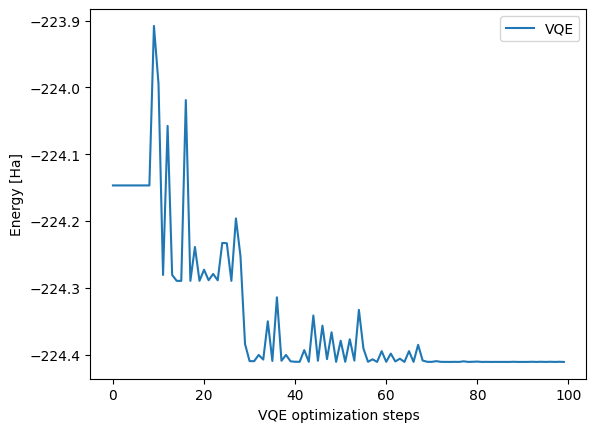

In [47]:
plt.xlabel("VQE optimization steps")
plt.ylabel("Energy [Ha]")
plt.plot(energies_vqe, label="VQE")
plt.legend()

In [48]:
#AFQMC

# generate input file for ipie
ipie_ham  = gen_ipie_input_from_pyscf_chk(file_chk,
                                          mcscf=True,
                                          chol_cut=1e-5)

h1e, chol, e0  = ipie_ham 

num_basis = chol.shape[1]
num_chol = chol.shape[0]

system = Generic(nelec=mol_nelec)

ham = HamGeneric(
    np.array([h1e, h1e]),
    chol.transpose((1, 2, 0)).reshape((num_basis * num_basis, num_chol)),
    e0,
)

# Build trial wavefunction

wavefunction = get_coeff_wf(final_state_vector,
                            n_elec=(num_active_electrons_alpha, num_active_electrons_beta)
                           )

trial = ParticleHole(
    wavefunction,
    mol_nelec,
    num_basis,
    num_dets_for_props=len(wavefunction[0]),
    verbose=True)

trial.compute_trial_energy = True
trial.build()
trial.half_rotate(ham)


 # Performing modified Cholesky decomposition on ERI tensor.
# Generating Cholesky decomposition of ERIs.
# max number of cholesky vectors = 1650
# iteration     0: delta_max = 4.785886
# iteration     1: delta_max = 4.77337369e+00: time = 1.21510029e-02
# iteration     2: delta_max = 4.71704611e+00: time = 2.36136913e-02
# iteration     3: delta_max = 9.09979426e-01: time = 2.00855732e-02
# iteration     4: delta_max = 9.00399998e-01: time = 2.43110657e-02
# iteration     5: delta_max = 8.44374457e-01: time = 2.08754539e-02
# iteration     6: delta_max = 4.53333155e-01: time = 1.80060863e-02
# iteration     7: delta_max = 4.53243727e-01: time = 2.31359005e-02
# iteration     8: delta_max = 4.53062225e-01: time = 2.32903957e-02
# iteration     9: delta_max = 3.28579026e-01: time = 2.93819904e-02
# iteration    10: delta_max = 3.27545060e-01: time = 2.23069191e-02
# iteration    11: delta_max = 3.27544777e-01: time = 2.47538090e-02
# iteration    12: delta_max = 3.27531397e-01: time = 2

In [49]:
afqmc_msd = AFQMC.build(
    mol_nelec,
    ham,
    trial,
    num_walkers=100,
    num_steps_per_block=25,
    num_blocks=10,
    timestep=0.005,
    stabilize_freq=5,
    seed=96264512,
    pop_control_freq=5,
    verbose=True,
)

afqmc_msd.run()
afqmc_msd.finalise(verbose=True)

# Computing trial wavefunction energy.
# Variational energy of trial wavefunction: -224.41097969955746
# random seed is 96264512
# Using pair_branch population control algorithm.
# target weight is 100
# total weight is 100
# ipie version: 0.7.0
# Calculation uuid: 70144930-24c4-11ef-b40e-a8a159c112ed.
# Approximate memory available per node: 503.5450 GB.
# Running on 1 MPI rank.
# Root processor name: gorby
# Python interpreter: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
# Using numpy v1.25.2 from: /usr/local/lib/python3.10/dist-packages/numpy.
# - BLAS lib: openblas64_ openblas64_
# - BLAS dir: /usr/local/lib
# Using scipy v1.10.1 from: /usr/local/lib/python3.10/dist-packages/scipy.
# Using h5py v3.11.0 from: /usr/local/lib/python3.10/dist-packages/h5py.
# Using mpi4py v3.1.6 from: /usr/local/lib/python3.10/dist-packages/mpi4py.
# - mpicc: /usr/local/openmpi/bin/mpicc
# Using cupy v13.1.0 from: /usr/local/lib/python3.10/dist-packages/cupy.
# - CUDA compute capability: 8.0
# -

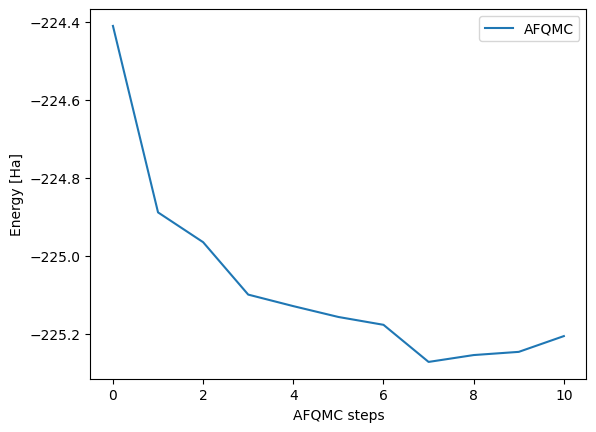

In [50]:
qmc_data = extract_observable(afqmc_msd.estimators.filename, "energy")
plt.xlabel("AFQMC steps")
plt.ylabel("Energy [Ha]")
plt.plot(qmc_data["ETotal"], label="AFQMC")
plt.legend()

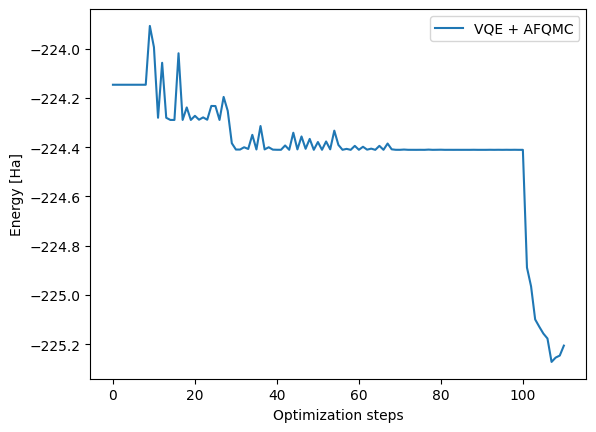

In [52]:
x = energies_vqe + list(qmc_data["ETotal"])
y = list(range(len(x)))

plt.xlabel("Optimization steps")
plt.ylabel("Energy [Ha]")
plt.plot(y, x, label="VQE + AFQMC")
plt.legend()